In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# data 
import numpy as np
import csv
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Prep Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                if(isinstance(val1,dict)) : 
                    print('\t',key1,end='')
                    for key2,val2 in val1.items():
                        print('\t\t',key2,'\t',len(val2))
                else : 
                    print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
triID_allZ = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(triID_allZ)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=422). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=671). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1638). ']
RED 	 422
GRN 	 671
BLU 	 1638


In [4]:
# get redshifts
zDict_all = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 487252


In [38]:
# D:\GitHub\IfA-REU-Project\Lists\New_Lx_cat.csv
# ID              146075,
# z               0.297000,
# Lx_05_10        9657046126737330166539869474683656807120896.000000,
# Lx_hard_2_10    5888442760205689578843837223116964479631360.000000,
# Nh              6658400349331484835840.000000

# ------------------------------------
# Lx_05_10      --> Lx_05_10_int
# Lx_hard_2_10  --> Lx_hard_2_10_int
# ------------------------------------

# D:\GitHub\IfA-REU-Project\Lists\New_Lx_cat_Nh_v2.csv
# ID                  146075,
# z                   0.297000,
# Lx_05_10_int        9657046126737330166539869474683656807120896.000000,
# Lx_05_10_obs        6729752848869575678026674911266406387417088.000000,
# Lx_hard_2_10_int    5888442760205689578843837223116964479631360.000000,
# Lx_hard_2_10_obs    5915607612348030687029162403042791683784704.000000,
# Nh                  6658400349331484835840.000000

In [41]:
# read file 
dataNew = adp.UnpackTable(adp.path_csv+'\\New_Lx_cat_Nh_v2.csv')

# fix types
dataNew['ID']               = np.array(dataNew['ID'], dtype=int)
dataNew['z']                = np.array(dataNew['z'],  dtype=float)
dataNew['Lx_05_10_int']     = np.log10(np.array(dataNew['Lx_05_10_int'],     dtype=float)) # log scale
dataNew['Lx_05_10_obs']     = np.log10(np.array(dataNew['Lx_05_10_obs'],     dtype=float)) # log scale
dataNew['Lx_hard_2_10_int'] = np.log10(np.array(dataNew['Lx_hard_2_10_int'], dtype=float)) # log scale
dataNew['Lx_hard_2_10_obs'] = np.log10(np.array(dataNew['Lx_hard_2_10_obs'], dtype=float)) # log scale
dataNew['Nh']               = np.log10(np.array(dataNew['Nh'], dtype=float)) # log scale


C:\Users\polar\AppData\Local\Temp\ipykernel_10336\3954359157.py:7: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_05_10_int']     = np.log10(np.array(dataNew['Lx_05_10_int'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_10336\3954359157.py:7: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_05_10_int']     = np.log10(np.array(dataNew['Lx_05_10_int'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_10336\3954359157.py:8: RuntimeWarning: divide by zero encountered in log10
  dataNew['Lx_05_10_obs']     = np.log10(np.array(dataNew['Lx_05_10_obs'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_10336\3954359157.py:8: RuntimeWarning: invalid value encountered in log10
  dataNew['Lx_05_10_obs']     = np.log10(np.array(dataNew['Lx_05_10_obs'],     dtype=float)) # log scale
C:\Users\polar\AppData\Local\Temp\ipykernel_10336\3954359157.py:9: RuntimeWarning: divide by zero encounte

In [75]:
def BuildAGNInfo(triID_allZ: dict, dataNew: dict, zDict_all: dict) -> dict[str,dict[str,np.array]]: 
    agnInfo = {}
    for colorKey, ids in triID_allZ.items() :
        # matching
        _, key_onZ = match.match(ids, zDict_all['ID'])
        _, key_onLx = match.match(ids, dataNew['ID'])
        # get data
        agnInfo[colorKey] = {
            'ID' : ids,
            'z'  : zDict_all['z'][key_onZ],
            'Lx' : dataNew['Lx_05_10_int'][key_onLx],
            'Lx Obs' : dataNew['Lx_05_10_obs'][key_onLx]
        }
    return agnInfo 

agnInfo = BuildAGNInfo(triID_allZ, dataNew, zDict_all)

In [76]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

In [77]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [78]:
# interpolates the luminosity at 1um
def Lum_at6um(lamFlam,lam,z) :
    lum_list = []
    for x,y,z in zip(lam,lamFlam,z) : 
        # interpolate
        f = SED.Interpolate_log(x,y)
        # normalize at 1um
        Fnu_at6um = SED.Flog_X(f,6*1E+4) # 6A * 10^4 = 6um
        # convert to luminosity
        lum_list.append(SED.Flux_to_Lum(Fnu_at6um,z))
    return(np.array(lum_list))

In [79]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # wavelengths
    lamR = SED.ConvertToRestWavelength(val['z'], print=False) # Rest
    lamO = np.array([SED.lam_A] * len(val['ID'])) # observed
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamO, Fnu, print=False)
    # get luminosity at 6um
    lum6um = np.log10( Lum_at6um(lamFlam, lamR, val['z'] ) )
    # append info
    val['L(6um)'] = lum6um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 422
	 z 	 422
	 Lx 	 422
	 Lx Obs 	 422
	 L(6um) 	 422
GRN	 ID 	 671
	 z 	 671
	 Lx 	 671
	 Lx Obs 	 671
	 L(6um) 	 671
BLU	 ID 	 1638
	 z 	 1638
	 Lx 	 1638
	 Lx Obs 	 1638
	 L(6um) 	 1638


In [80]:
agnInfo_yX = {}
agnInfo_nX = {}
for colorKey,agnValDict in agnInfo.items():
    # get indices where Lx is nan
    yXmask = np.ones(len(agnValDict['Lx']), dtype=bool)
    yXmask[ np.concatenate( (
                np.argwhere(np.isnan(agnValDict['Lx'])).T [0],  # where Lx is nan
                np.where(agnValDict['Lx'] <= 0) [0]             # where Lx is negative
    ))] = False
    # split dict into dics that have (y) or dont have (n) an Lx (X)
    agnInfo_yX[colorKey] = {}
    agnInfo_nX[colorKey] = {}
    for key,val in agnValDict.items() : 
        agnInfo_yX[colorKey][key] = val[yXmask]
        agnInfo_nX[colorKey][key] = val[~yXmask]

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX) # only RED should have nX

~~~~ yX ~~~~~
RED	 ID 	 17
	 z 	 17
	 Lx 	 17
	 Lx Obs 	 17
	 L(6um) 	 17
GRN	 ID 	 671
	 z 	 671
	 Lx 	 671
	 Lx Obs 	 671
	 L(6um) 	 671
BLU	 ID 	 1638
	 z 	 1638
	 Lx 	 1638
	 Lx Obs 	 1638
	 L(6um) 	 1638
~~~~ nX ~~~~~
RED	 ID 	 405
	 z 	 405
	 Lx 	 405
	 Lx Obs 	 405
	 L(6um) 	 405
GRN	 ID 	 0
	 z 	 0
	 Lx 	 0
	 Lx Obs 	 0
	 L(6um) 	 0
BLU	 ID 	 0
	 z 	 0
	 Lx 	 0
	 Lx Obs 	 0
	 L(6um) 	 0


In [81]:
# returns array of ( min <= z < max )
def GetMaskFromRedshiftsInRange(
        zArr,    # np array of z  
        min=0,   # minimum
        max=99,  # maximum 
        incusiveMin=False,
) : 
    # get mask of indecies that are in redshift range (true)
    if(incusiveMin):
        return (zArr >= min) & (zArr < max)
    else: 
        return (zArr >  min) & (zArr <= max)

In [82]:
def GetAGNinZrange(agnInfo_Xx : dict[str,dict[str,np.array]]):
    agnInfo_xX_byZ = {}
    for colorKey,agnDict in agnInfo_Xx.items() : 
        agnInfo_xX_byZ[colorKey] = {}
        # get masks for each redshift bin 
        zArray = agnDict['z']
        zMasks = {
            '$0 < z \leq 1$'   : GetMaskFromRedshiftsInRange(zArray,          max=1  ),
            '$1 < z \leq 1.5$' : GetMaskFromRedshiftsInRange(zArray, min=1,   max=1.5),
            '$1.5 < z \leq 2$' : GetMaskFromRedshiftsInRange(zArray, min=1.5, max=2  ),
            '$2 < z \leq 3$'   : GetMaskFromRedshiftsInRange(zArray, min=2,   max=3  ),
            '$3 < z \leq 6$'   : GetMaskFromRedshiftsInRange(zArray, min=3           )
        }
        for zKey, zArr in zMasks.items() : 
            agnInfo_xX_byZ[colorKey][zKey] = {}
            for agnDictKey, agnDictVal in agnDict.items() : 
                agnInfo_xX_byZ[colorKey][zKey][agnDictKey] = agnDictVal[zArr]
    return agnInfo_xX_byZ

agnInfo_yX_byZ = GetAGNinZrange(agnInfo_yX)
agnInfo_nX_byZ = GetAGNinZrange(agnInfo_nX)

# verify number of sources
print('~~~~ yX ~~~~~')
PrintNumber(agnInfo_yX_byZ)
print('~~~~ nX ~~~~~')
PrintNumber(agnInfo_nX_byZ) # only RED should have nX

~~~~ yX ~~~~~
RED	 $0 < z \leq 1$		 ID 	 17
		 z 	 17
		 Lx 	 17
		 Lx Obs 	 17
		 L(6um) 	 17
	 $1 < z \leq 1.5$		 ID 	 0
		 z 	 0
		 Lx 	 0
		 Lx Obs 	 0
		 L(6um) 	 0
	 $1.5 < z \leq 2$		 ID 	 0
		 z 	 0
		 Lx 	 0
		 Lx Obs 	 0
		 L(6um) 	 0
	 $2 < z \leq 3$		 ID 	 0
		 z 	 0
		 Lx 	 0
		 Lx Obs 	 0
		 L(6um) 	 0
	 $3 < z \leq 6$		 ID 	 0
		 z 	 0
		 Lx 	 0
		 Lx Obs 	 0
		 L(6um) 	 0
GRN	 $0 < z \leq 1$		 ID 	 108
		 z 	 108
		 Lx 	 108
		 Lx Obs 	 108
		 L(6um) 	 108
	 $1 < z \leq 1.5$		 ID 	 151
		 z 	 151
		 Lx 	 151
		 Lx Obs 	 151
		 L(6um) 	 151
	 $1.5 < z \leq 2$		 ID 	 161
		 z 	 161
		 Lx 	 161
		 Lx Obs 	 161
		 L(6um) 	 161
	 $2 < z \leq 3$		 ID 	 208
		 z 	 208
		 Lx 	 208
		 Lx Obs 	 208
		 L(6um) 	 208
	 $3 < z \leq 6$		 ID 	 43
		 z 	 43
		 Lx 	 43
		 Lx Obs 	 43
		 L(6um) 	 43
BLU	 $0 < z \leq 1$		 ID 	 454
		 z 	 454
		 Lx 	 454
		 Lx Obs 	 454
		 L(6um) 	 454
	 $1 < z \leq 1.5$		 ID 	 517
		 z 	 517
		 Lx 	 517
		 Lx Obs 	 517
		 L(6um) 	 517
	 $1.5 < z \leq 2$		 

In [83]:
def GetRedUpperLimits(red) -> dict : 
    # read file 
    dataCorrOrig = adp.UnpackTable(adp.path_csv+'\\Lx_correction_plot_data_update.csv') # ID,Lx_corr,log_Lx_int,log_Lx_obs,group
    dataCorr = {
        'ID' : np.array(dataCorrOrig['ID'], dtype=int), 
        'log_Lx_obs' : np.array(dataCorrOrig['log_Lx_obs'], dtype=float) } 
    # match ids
    keyRed, keyCorr = match.match(red['ID'], dataCorr['ID'])
    # build dict
    addDict = {}
    for key,val in red.items() : 
        addDict[key] = val[keyRed]
    addDict['Lx'] = dataCorr['log_Lx_obs'][keyCorr]
    return addDict

redUpperLims = GetRedUpperLimits(agnInfo_nX['RED'])
print(redUpperLims.keys()) # dict_keys(['ID', 'z', 'Lx', 'L(6um)'])

dict_keys(['ID', 'z', 'Lx', 'Lx Obs', 'L(6um)'])


# Histogram to test L(6um)

In [84]:
def TestHist() : 
    adp.SetStyle()
    plt.hist(agnInfo['RED']['L(6um)'], bins=np.arange(38,48,0.5), histtype='step', edgecolor=adp.c_ir,      linewidth=2)
    plt.hist(agnInfo['GRN']['L(6um)'], bins=np.arange(38,48,0.5), histtype='step', edgecolor=adp.c_ir_xray, linewidth=2)
    plt.hist(agnInfo['BLU']['L(6um)'], bins=np.arange(38,48,0.5), histtype='step', edgecolor=adp.c_xray,    linewidth=2)
    ax = plt.gca()
    adp.MeanLineForHist_ax(ax,agnInfo['RED']['L(6um)'],c=adp.c_ir,      xtext=0.99,ytext=0.94,pre='',horizAlign='right')
    adp.MeanLineForHist_ax(ax,agnInfo['GRN']['L(6um)'],c=adp.c_ir_xray, xtext=1.01,ytext=0.89,pre='',horizAlign='left')
    adp.MeanLineForHist_ax(ax,agnInfo['BLU']['L(6um)'],c=adp.c_xray,    xtext=1.01,ytext=0.84,pre='',horizAlign='left')

# TestHist()

# Lx vs L(6um) Scatterplot

In [85]:
def FuncChen2017(x: np.array) : 
    # https://ui.adsabs.harvard.edu/abs/2017ApJ...837..145C/abstract
    #   The best-fitting parameters for ( L log 6um , m1, m2, b1, b2) are (44.79, 0.84, 0.40, 44.60, 44.51), 
    #       and the corresponding uncertainties are (0.11, 0.03, 0.03, 0.01, 0.01 ). 
    # x = log(L(6um)/1e45[erg/s]) = log(L(6um)) - 45
    # y = log(Lx)
    m = np.array([ 0.84 if xp < 44.79 else  0.40 for xp in x])
    b = np.array([44.60 if xp < 44.79 else 44.51 for xp in x])
    # log(Lx) = m * log(L6um/1e45) + b =  m1 * (log(L6um) - 45) + b
    y = ( m * (x - 45.0) ) + b
    # correct for 0.5-10 keV: y = log (Lx * 1.64) = log (Lx) + log( 1.64 ) 
    y = y + np.log10(1.64)
    return y

def DrawChenLine(ax, xmin=40, xmax=50) : 
    x = np.linspace(xmin, xmax, 100)
    y = FuncChen2017(x)
    ax.plot(x,y, c='k', linewidth=1.5, linestyle='--', label='Chen+2017')

def TestChen() : 
    adp.SetStyle()
    fig, ax = plt.subplots(1)
    DrawChenLine(ax)

# TestChen()

In [86]:
def FuncStern(x) : 
    # y = 40.981 + 1.024x - 0.047x^2
    #   where: 
    #       y = log (Lx) 
    #       x = log (L(6um) / 1e41) = log (L(6um)) - 41
    y = (40.981 + ( 1.024 * (x - 41) ) - ( 0.047 * ((x - 41) ** 2) ))
    #   y = log (Lx * 1.64) = log (Lx) + log( 1.64 ) 
    y = y + np.log10(1.64)
    return y

def DrawSternLine(ax, xmin=40, xmax=50) : 
    x = np.linspace(xmin, xmax, 100)
    y = FuncStern(x)
    ax.plot(x,y, c='k', linewidth=1.5, linestyle='-', label='Stern+2015')

def TestStern() : 
    adp.SetStyle()
    fig, ax = plt.subplots(1)
    DrawSternLine(ax)

# TestStern()

In [87]:
def PlotLine(ax,a,b,xmin,xmax,linestyle='--') : 
    x = np.linspace(xmin,xmax)
    ax.plot(x, a*x+b, color='k', linestyle=linestyle, linewidth=1.5)    
    print('y = ' + '{:.2f}'.format(b) + ' + {:.2f}'.format(a) + 'x')

In [88]:
def PlotTricolor_ax(
    ax,
    x_red, y_red, # x = L(6um), y = Lx
    x_grn, y_grn,
    x_blu, y_blu,
    x_redLL=[], y_redLL=[], # lower limits
    fullText=''
) :
    # plot data
    ax.scatter(x_blu, y_blu, marker='s', c=adp.c_xray,     s=3) #, label='Exclusive X-ray (n='+str(len(x_blu))+')')
    ax.scatter(x_red, y_red, marker='^', c=adp.c_ir,       s=3) #, label='Exclusive MIR (n='+  str(len(x_red))+')')
    ax.scatter(x_grn, y_grn, marker='o', c=adp.c_ir_xray,  s=3) #, label='Inclusive (n='+      str(len(x_grn))+')')
    if( len(x_redLL) > 0 and len(y_redLL) > 0) : 
        ax.scatter(x_redLL, y_redLL, marker='^', c='none', edgecolors=adp.c_ir, linewidths=0.5, s=8, alpha=0.5) #, label='Exclusive MIR (n='+  str(len(x_red))+')')

    DrawSternLine(ax)
    DrawChenLine(ax)
    adp.PlotContours_ax( ax, np.concatenate([x_blu,x_red,x_grn]), np.concatenate([y_blu,y_red,y_grn]) )
    # decorations
    adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    if(fullText != '') : adp.AddText_z_ax(ax, fullText)
    # axis settings
    ax.set_aspect('equal')
    ax.set_adjustable('box') 
    ax.set_xlim([41.5,47.5])
    ax.set_ylim([41.75,46])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

In [89]:
def PlotResidual(
    ax,
    x_red,
    y_red,
    x_grn,
    y_grn,
    x_blu,
    y_blu,
    func=FuncStern,
    nText=False,
    zText='',
    linestyle='-'
) : 
    # get difference for residual
    res_red = y_red - func(x_red)
    res_grn = y_grn - func(x_grn)
    res_blu = y_blu - func(x_blu)
    # plot data
    ax.scatter(x_blu, res_blu, marker='s', s=2, c=adp.c_xray    )
    ax.scatter(x_red, res_red, marker='^', s=2, c=adp.c_ir      )
    ax.scatter(x_grn, res_grn, marker='o', s=2, c=adp.c_ir_xray )
    ax.axhline(y=0, xmin=0, xmax=99, color='k', linestyle=linestyle, linewidth=1)
    adp.PlotContours_ax( ax, np.concatenate([x_blu,x_red,x_grn]), np.concatenate([res_blu,res_red,res_grn]) )
    # deco
    if(zText != '') : adp.AddText_z_ax(ax, zText)
    if(nText) : adp.AddText_n_ax(ax,len(x_blu)+len(x_red)+len(x_grn), pre='$\mathrm{N_{total}}$ = ')
    # axis settings
    ax.set_xlim([41.5,47.5])
    ax.set_ylim([-2.5,2.5])
    ax.set_adjustable('box') 
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))

def ResidualFromLine(ax, xmin, xmax, func1, func2, color='k', linestyle='-') : 
    x = np.linspace(xmin,xmax)
    y = func1(x) - func2(x)
    ax.plot(x, y, c=color,  linewidth=1.5, linestyle=linestyle) # dashed

In [90]:
def AddRedLineStuff(ax, agnInfo_nX_byZ) : 
    # collect data
    nx = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        nx = np.concatenate((nx,agninfodict['L(6um)']))
    # stats
    center = np.mean(nx)
    std = np.std(nx) 
    print('STATS:\t', center-std, center, center+std)
    print('STERN:\t', FuncStern(center-std), FuncStern(center), FuncStern(center+std))
    print('CHEN:\t',  FuncChen2017(np.array([center-std])), FuncChen2017(np.array([center])), FuncChen2017(np.array([center+std])))
    for axi in ax : 
        # draw average line 
        axi.axvline( center, 0,1, c=adp.c_ir, linewidth=1, linestyle='dotted' )
        # draw 1 std dev from mean 
        axi.axvline( center+std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) ) # spaced dotted line
        axi.axvline( center-std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) )

In [91]:
def AddMiniRedHist(ax,agnInfo_nX_byZ,c=adp.c_ir) : 
    # collect data
    x = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        x = np.concatenate((x,agninfodict['L(6um)']))
    # plot
    ax.hist(x, bins=np.arange(41.5,47.5,0.25),histtype='step', color=c, linewidth=1)
    ax.set_ylabel('Number')
    ax.set_ylim([0,80])
    ax.set_yticks([0,25,50,75])
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    adp.AddText_n_ax(ax,len(x), pre='$\mathrm{n_{IRAC}}$ = ')

In [92]:
def PlotStern2015(
    agnInfo_yX,
    agnInfo_nX_byZ,
    save = None,
    fitLine=True,
    useFitlineAsResidualReference = False,
    redidualLines=[FuncStern, FuncChen2017], # empty list means no residual plot, 0 index used as reference for residual
    linestyles=['-','--'],
    redUpperLims = None,
    miniRedhist = False,
    plotStdDev = True,
) :
    # build figure 
    adp.SetStyle() 
    if(redidualLines != []) : 
        fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', facecolor='w', sharex=True, 
                               gridspec_kw={'height_ratios': [3,1]}, figsize=(6,6.1))
    elif(miniRedhist) : 
        fig, ax = plt.subplots(nrows=2, ncols=1, layout='constrained', facecolor='w', sharex=True, 
                               gridspec_kw={'height_ratios': [5.5,1]}, figsize=(6,5.3), )
    else : 
        fig, ax = plt.subplots(layout='constrained', facecolor='w')
        ax = [ax]

    # lower limits for red
    x_redLL=[]
    y_redLL=[]
    if(redUpperLims != None ) : 
        x_redLL=redUpperLims['L(6um)']
        y_redLL=redUpperLims['Lx']
        
    # Lx vs 6um
    PlotTricolor_ax(
        ax=ax[0], fullText = '$0 < z \leq 6$',
        x_red = agnInfo_yX['RED']['L(6um)'],  y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'],  y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  y_blu = agnInfo_yX['BLU']['Lx'],
        x_redLL=x_redLL, y_redLL=y_redLL,
    )
    # lables 
    ax[0].set_ylabel('$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$')
    ax[0].legend(loc='upper right')

    # line of best fit  
    if(fitLine) : 
        # prep data
        xAll = np.concatenate((agnInfo_yX['RED']['L(6um)'], agnInfo_yX['GRN']['L(6um)'], agnInfo_yX['BLU']['L(6um)']))
        yAll = np.concatenate((agnInfo_yX['RED']['Lx'], agnInfo_yX['GRN']['Lx'], agnInfo_yX['BLU']['Lx']))
        # fit line 
        a, b = np.polyfit(xAll, yAll, 1)
        def fitlinefunc(x) : return (a*x+b)
        # add lines to lists 
        if(useFitlineAsResidualReference) : 
            redidualLines = [fitlinefunc] + redidualLines
            linestyles = [(0, (5, 5))] + linestyles
        else : 
            redidualLines = redidualLines + [fitlinefunc] 
            linestyles = linestyles + [(0, (5, 5))]
        # draw line on plot 
        intersect43 = (43-b) / a # solve for y in y=mx+b
        PlotLine(ax[0],a,b, intersect43,50, '-.')

    # add residual plot 
    if(len(redidualLines)>1): 
        # plotAGNs
        PlotResidual(
            ax=ax[1],
            x_red = agnInfo_yX['RED']['L(6um)'], y_red = agnInfo_yX['RED']['Lx'],
            x_grn = agnInfo_yX['GRN']['L(6um)'], y_grn = agnInfo_yX['GRN']['Lx'],
            x_blu = agnInfo_yX['BLU']['L(6um)'], y_blu = agnInfo_yX['BLU']['Lx'],
            func  = redidualLines[0], linestyle = linestyles[0]
        ) 
        # calculate residual lines 
        for line, style in zip(redidualLines[1:],linestyles[1:]) : 
            xmin = 40
            if(fitLine) : 
                if(line == fitlinefunc) : 
                    xmin = intersect43
            ResidualFromLine(ax=ax[1], xmin=xmin, xmax=50, func1=line, func2=redidualLines[0], color='k', linestyle=style)
        # lables 
        ax[1].set_ylabel('Residual')
        ax[1].set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    elif(miniRedhist) : 
        AddMiniRedHist(ax[1],agnInfo_nX_byZ)
        ax[1].set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    else :
        ax[0].set_xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')

    # show nX AGNs with median and 1sigma lines
    if(plotStdDev) :
        AddRedLineStuff(ax, agnInfo_nX_byZ) 
    
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()


STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206
CHEN:	 [43.71698377] [44.42342008] [44.87484982]


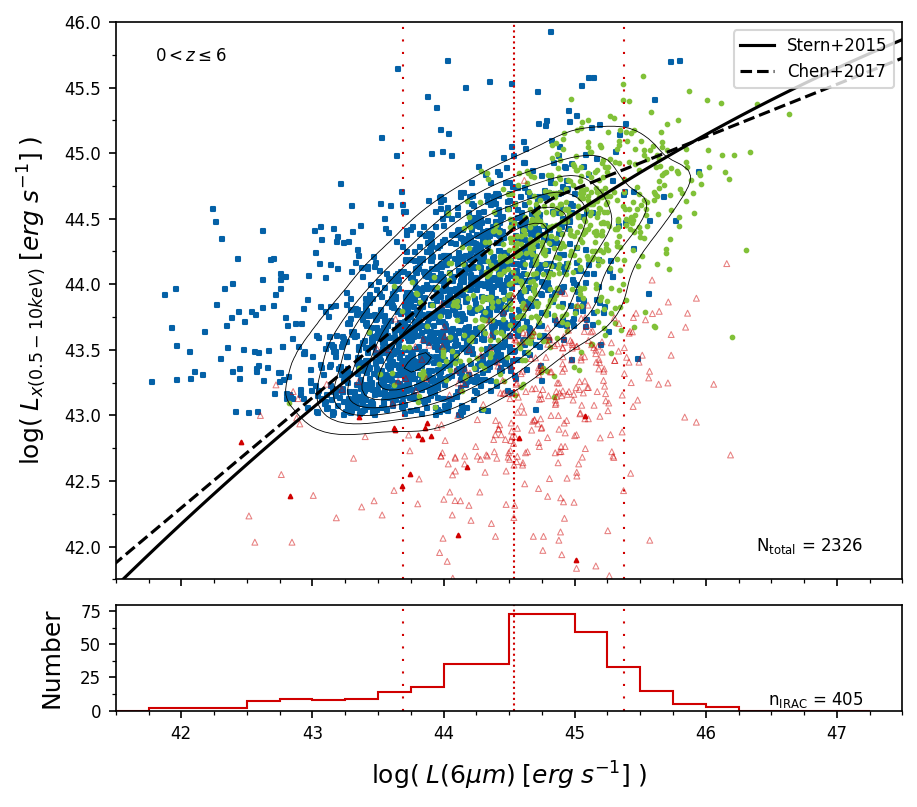

In [93]:
PlotStern2015(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll_RLL_withHist.pdf',
            fitLine=False, 
            redidualLines=[],
            redUpperLims=redUpperLims,
            miniRedhist=True
)

STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206
CHEN:	 [43.71698377] [44.42342008] [44.87484982]


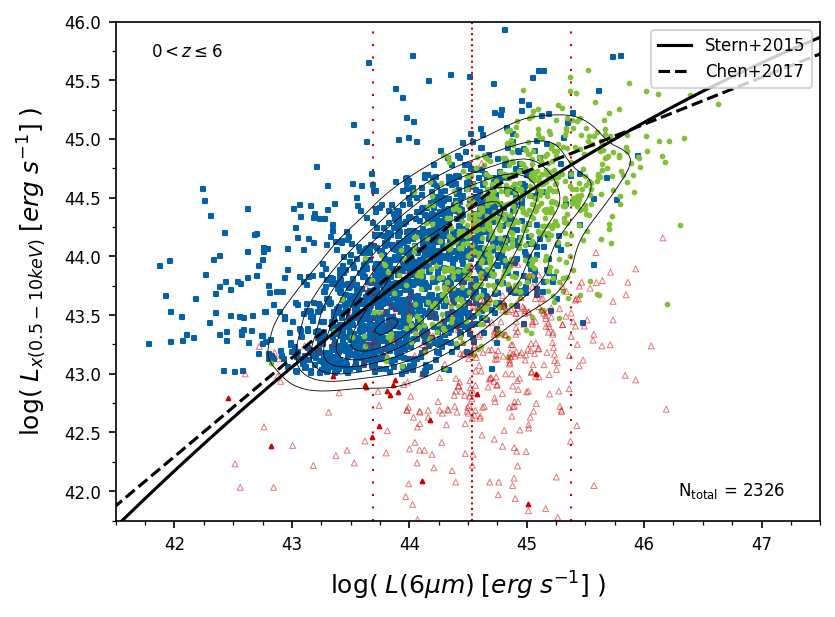

In [94]:

PlotStern2015(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll_RLL.pdf',
            fitLine=False, 
            redidualLines=[],
            redUpperLims=redUpperLims,
            miniRedhist = False,
            # plotStdDev = False
)

STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206
CHEN:	 [43.71698377] [44.42342008] [44.87484982]


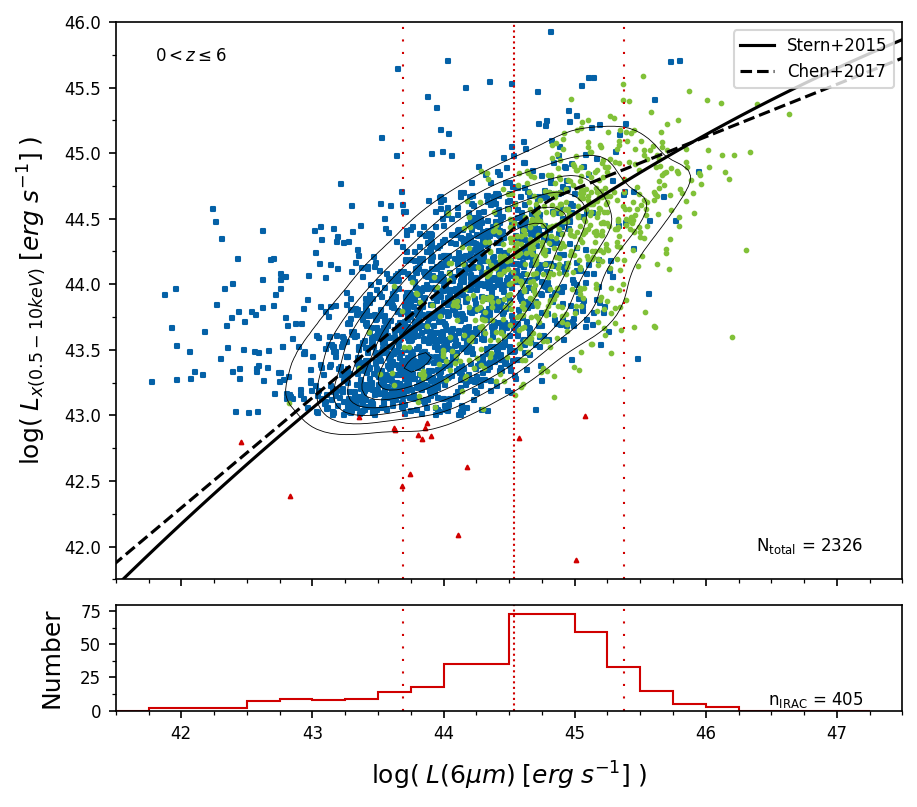

In [95]:
PlotStern2015(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll_withHist.pdf',
            fitLine=False, 
            redidualLines=[],
            miniRedhist=True
)

In [96]:
# PlotStern2015(
#             agnInfo_yX,
#             agnInfo_nX_byZ,
#             fitLine=True, 
#             redidualLines=[FuncChen2017, FuncStern], 
#             linestyles=['--','-'],
# )

In [97]:
# PlotStern2015(
#             agnInfo_yX,
#             agnInfo_nX_byZ,
#             save=adp.path_fig + '\\v2_LxVsL6um_zAll_res_fit.pdf',
#             fitLine=True, 
# )

STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206
CHEN:	 [43.71698377] [44.42342008] [44.87484982]


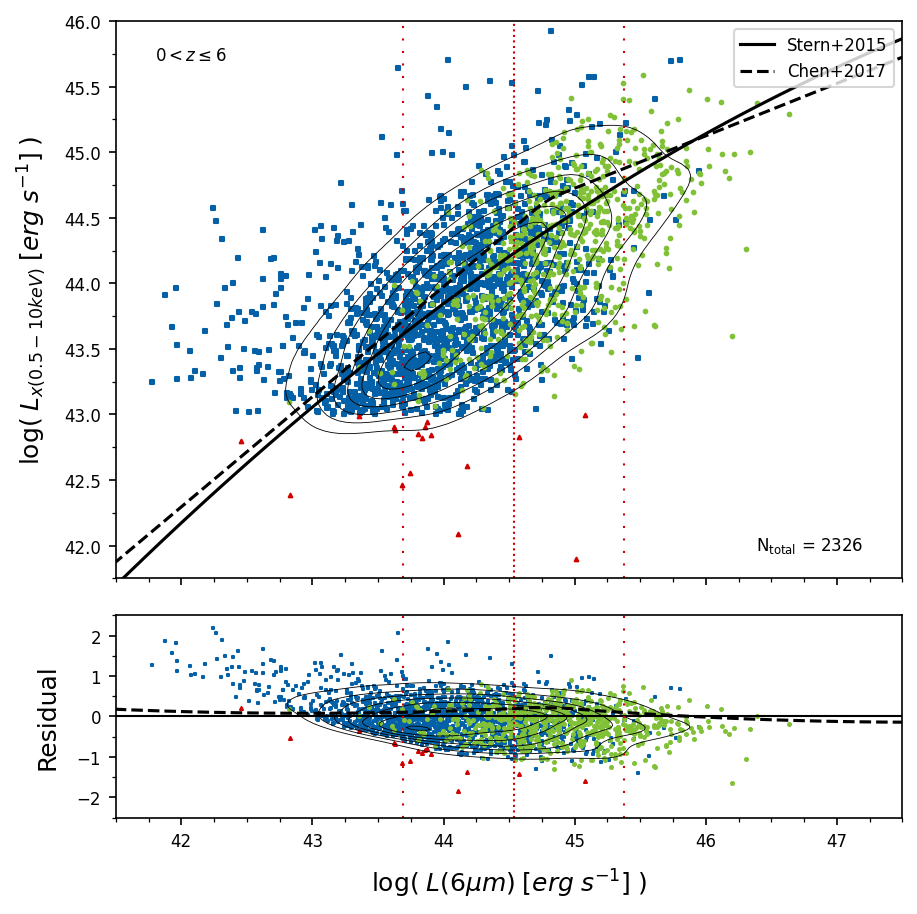

In [98]:
PlotStern2015(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll_res.pdf',
            fitLine=False, 
)

STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206
CHEN:	 [43.71698377] [44.42342008] [44.87484982]


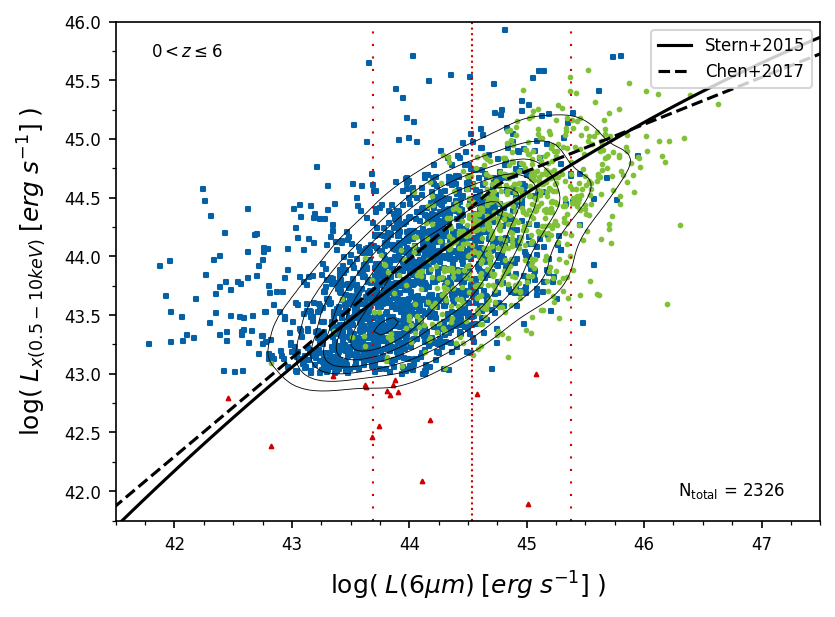

In [99]:
PlotStern2015(
            agnInfo_yX,
            agnInfo_nX_byZ,
            save=adp.path_fig + '\\v2_LxVsL6um_zAll.pdf',
            fitLine=False, 
            redidualLines=[],
)

In [100]:
# PlotStern2015(
#             agnInfo_yX,
#             agnInfo_nX_byZ,
#             save=adp.path_fig + '\\v2_LxVsL6um_zAll_fit.pdf',
#             fitLine=True, 
#             redidualLines=[],
# )

# Big Panel Scatterplot

In [101]:
def PlotStern2015_res_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save = None
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)
    fig.set_figheight((2*1.5))    
    fig.set_figwidth((3*3)-0.2)   

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotResidual(
        ax=ax[0][0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        nText = True,
        zText = '$0 < z \leq 6$',
    )
    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotResidual(
            ax=ax[row][col],
            x_red = agnInfo_yX_byZ['RED'][zrange]['L(6um)'], 
            y_red = agnInfo_yX_byZ['RED'][zrange]['Lx'],
            x_grn = agnInfo_yX_byZ['GRN'][zrange]['L(6um)'], 
            y_grn = agnInfo_yX_byZ['GRN'][zrange]['Lx'],
            x_blu = agnInfo_yX_byZ['BLU'][zrange]['L(6um)'],  
            y_blu = agnInfo_yX_byZ['BLU'][zrange]['Lx'],
            nText = True,
            zText = zrange
        )
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
        plt.xlabel('')
    
    # finish 
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
        'Residual',
        save, (0.5, -0.04), (-0.03, 0.5)
    )

# PlotStern2015_res_rectangle(
#     agnInfo_yX,
#     agnInfo_yX_byZ,
#     save=adp.path_fig + '\\v2_LxVsL6um_res_rect.pdf'
# )

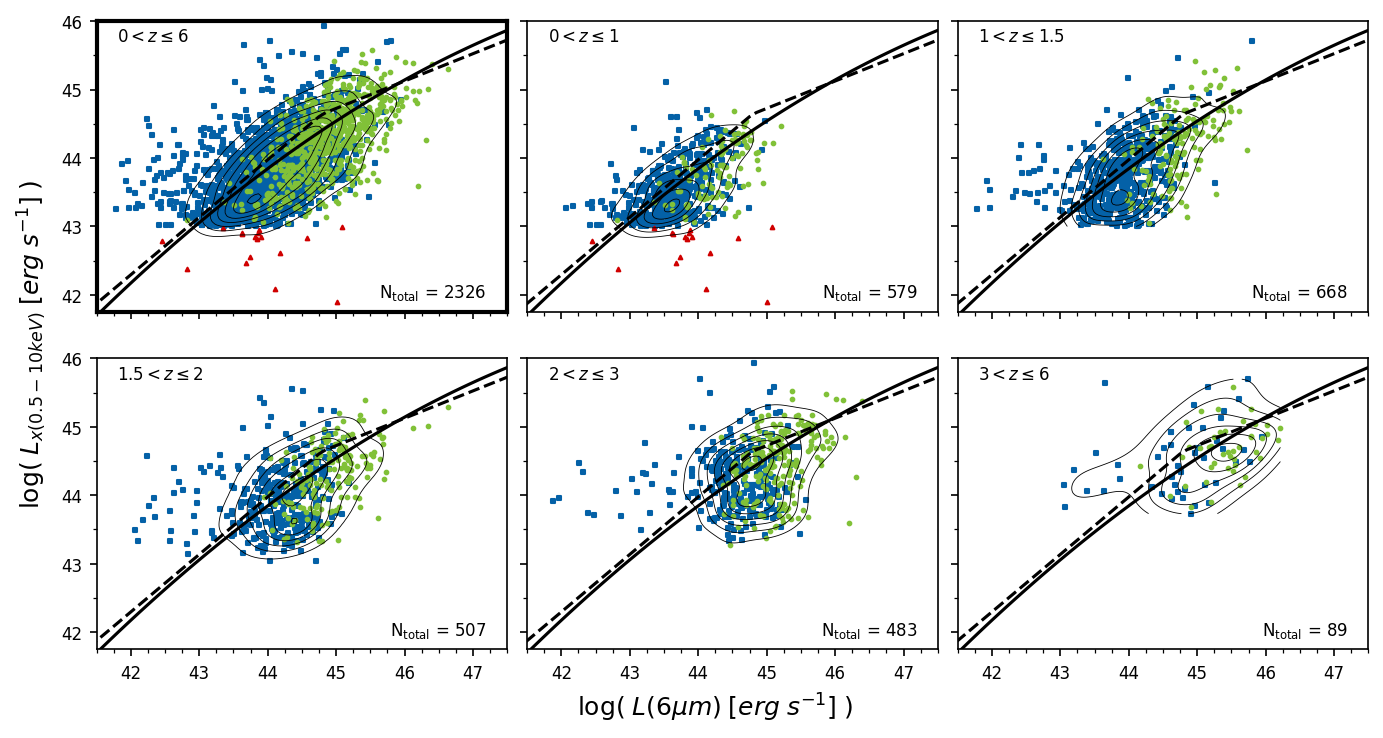

In [102]:
def PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save = None
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)
    fig.set_figheight((2*2.3))    
    fig.set_figwidth((3*3)-0.2)   

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotTricolor_ax(
        ax=ax[0][0],
        x_red = agnInfo_yX['RED']['L(6um)'], 
        y_red = agnInfo_yX['RED']['Lx'],
        x_grn = agnInfo_yX['GRN']['L(6um)'], 
        y_grn = agnInfo_yX['GRN']['Lx'],
        x_blu = agnInfo_yX['BLU']['L(6um)'],  
        y_blu = agnInfo_yX['BLU']['Lx'],
        fullText = '$0 < z \leq 6$'
    )

    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotTricolor_ax(
            ax=ax[row][col],
            x_red = agnInfo_yX_byZ['RED'][zrange]['L(6um)'], 
            y_red = agnInfo_yX_byZ['RED'][zrange]['Lx'],
            x_grn = agnInfo_yX_byZ['GRN'][zrange]['L(6um)'], 
            y_grn = agnInfo_yX_byZ['GRN'][zrange]['Lx'],
            x_blu = agnInfo_yX_byZ['BLU'][zrange]['L(6um)'],  
            y_blu = agnInfo_yX_byZ['BLU'][zrange]['Lx'],
            fullText=zrange
        )
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
        plt.xlabel('')
    
    # finish 
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
        '$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
        save, (0.5, -0.04), (-0.03, 0.5)
    )

PlotStern2015_rectangle(
    agnInfo_yX,
    agnInfo_yX_byZ,
    save=adp.path_fig + '\\v2_LxVsL6um_rect.pdf'
)

# Histogram

In [103]:
def PlotL6umHist(ax, x: list, c: list, textN=True, fullText='$0 < z \leq 1$', h=250, xtext=0.98) :
    ax.set_ylim(ymin=0, ymax=h)
    Ntot = 0
    lableHight = 0.94
    for xi, ci in zip(x,c) :
        if(len(xi)!=0) :
            ax.hist(xi, histtype='step', color=ci, linewidth=2)
            adp.MeanLineForHist_ax(ax=ax,x=xi,c=ci,xtext=xtext,ytext=lableHight,horizAlign='right',pre='')
            Ntot += len(xi)
            lableHight -= 0.05
    ax.xaxis.set_minor_locator(AutoMinorLocator(4))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if(textN) : adp.AddText_n_ax(ax,Ntot)
    adp.AddText_z_ax(ax, fullText=fullText)

STATS:	 43.69302371321265 44.53401931915873 45.37501492510481
STERN:	 43.61263842454095 44.22768288110145 44.776243618395206


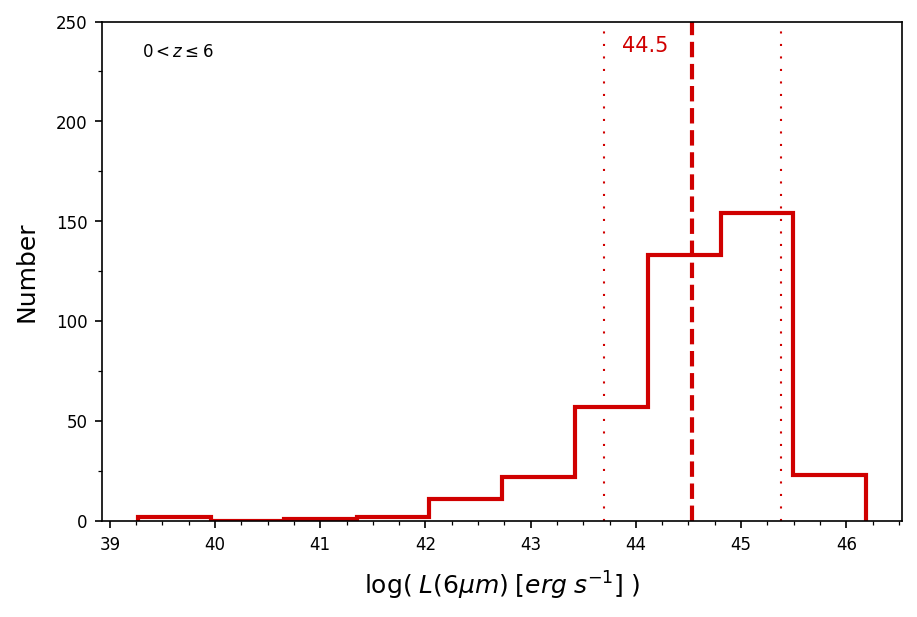

In [104]:
def ShowL6umForNX(agnInfo_nX_byZ, save=None) : 
    adp.SetStyle() 
    fig, ax = plt.subplots(layout='constrained', facecolor='w')
    # get data
    x = np.array([])
    for zrange, agninfodict in agnInfo_nX_byZ['RED'].items() : 
        x = np.concatenate((x,agninfodict['L(6um)']))
    # plot
    PlotL6umHist(ax, [x],[adp.c_ir], fullText='$0 < z \leq 6$',textN=False,xtext=0.995)

    # extra stats
    center = np.mean(x)
    std = np.std(x) 
    print('STATS:\t', center-std, center, center+std)
    print('STERN:\t', FuncStern(center-std), FuncStern(center), FuncStern(center+std))
    # draw 1 std dev from mean 
    ax.axvline( center+std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) ) # spaced dotted line
    ax.axvline( center-std, 0,1, c=adp.c_ir, linewidth=1, linestyle=(0, (1, 5)) )

    # lables 
    plt.xlabel('$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    # finish
    if(save): adp.Save(save)
    plt.show()
    plt.close()

ShowL6umForNX(
    agnInfo_nX_byZ,
    save=adp.path_fig + '\\v2_L6um_noLx_hist_justRED.pdf'    
)

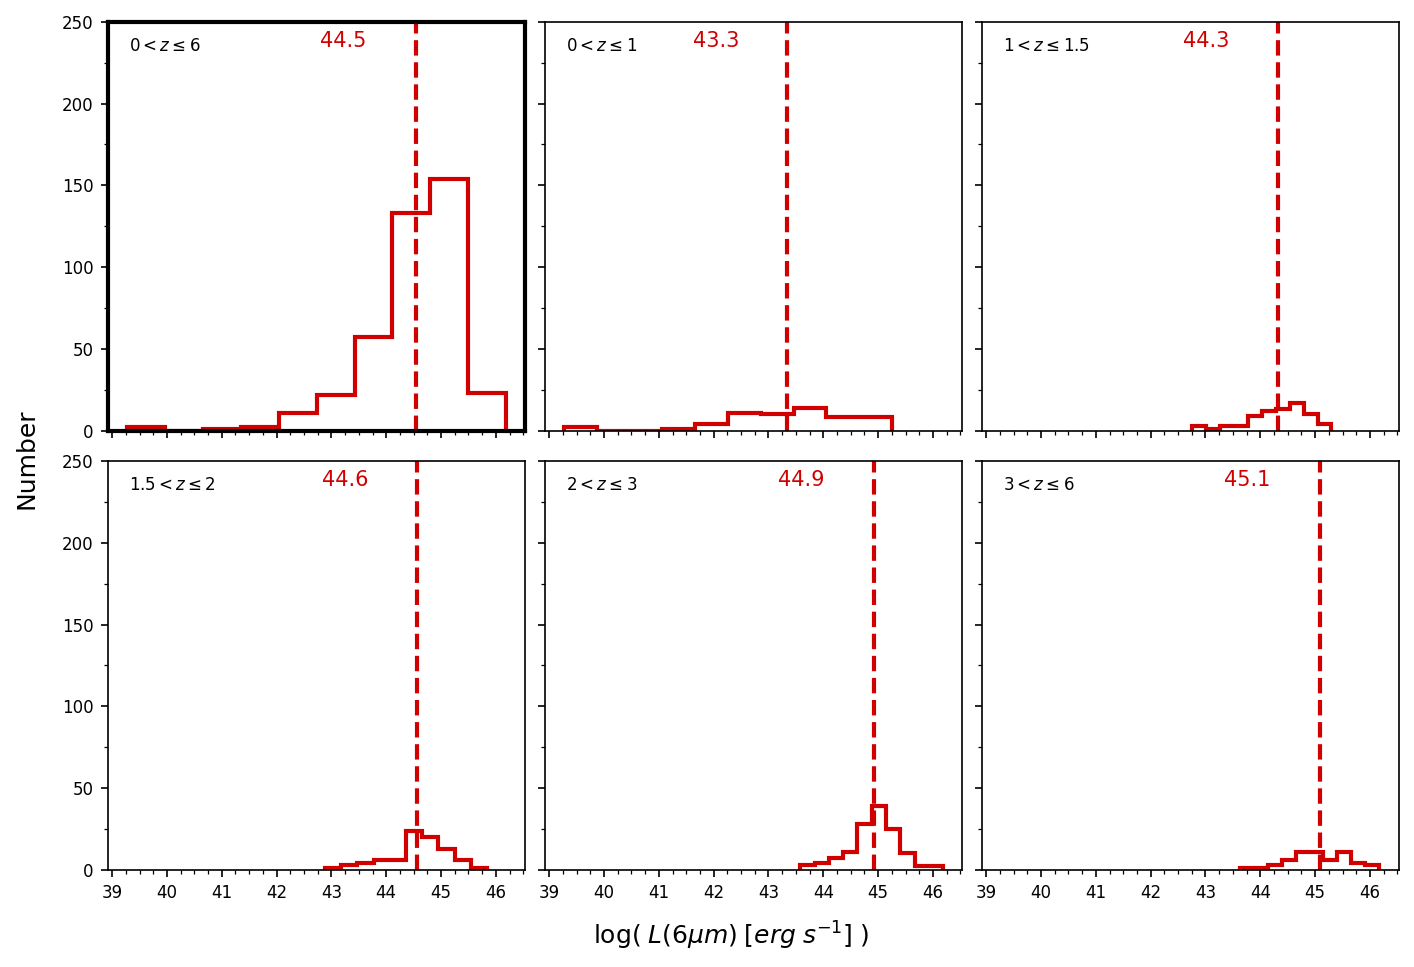

In [105]:
def PlotStern2015_rectangle(
    agnInfo_nX,
    agnInfo_nX_byZ,
    save = None,
) :
    # setup plot 
    fig, ax = adp.ByZ_SetupFig_Rectangle(2,3)

    # plot all 
    adp.BoldSubplot(ax[0][0])
    PlotL6umHist(ax[0][0],
                 [agnInfo_nX['RED']['L(6um)'],agnInfo_nX['GRN']['L(6um)'],agnInfo_nX['BLU']['L(6um)']],
                 [adp.c_ir, adp.c_ir_xray, adp.c_xray],
                 fullText='$0 < z \leq 6$', 
                 h=250, textN=False)

    # make plot for each redshift range
    row = 0
    col = 1
    z = ['$0 < z \leq 1$','$1 < z \leq 1.5$','$1.5 < z \leq 2$' ,'$2 < z \leq 3$','$3 < z \leq 6$'   ]
    for zrange in z :  
        PlotL6umHist(ax[row][col],
                 [agnInfo_nX_byZ['RED'][zrange]['L(6um)'],
                  agnInfo_nX_byZ['GRN'][zrange]['L(6um)'],
                  agnInfo_nX_byZ['BLU'][zrange]['L(6um)']],
                 [adp.c_ir, adp.c_ir_xray, adp.c_xray],
                 fullText=zrange,
                 h=250, textN=False)
        # increment plot
        if(col < 2) : 
            col += 1
        else : 
            col = 0
            row +=1
    
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L(6 \mu m) \; [erg \; s^{-1}] \;)$',
        'Number',
        save, (0.5, -0.04), (-0.03, 0.5)
    )

PlotStern2015_rectangle(
    agnInfo_nX,
    agnInfo_nX_byZ,
    save=adp.path_fig + '\\v2_L6um_noLx_hist.pdf'    
)

# Save To File

In [110]:
with open(adp.path_csv+'\\AGN_L6um-Lx_forNHestim.csv', mode='w', newline='') as csv_file:
    # initialize csv
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write to file 
    writer.writerow(['ID','group', 'z', 'L(6um)', 'Lx(0.5-10)int', 'Lx(0.5-10)obs', 'Lx_limit'])

    # for RED/GRN/BLU
    for group, infoDict in agnInfo.items() : 
        # for each AGN
        for i in range(len(infoDict['ID'])) : 
            # get info
            id   = infoDict['ID'][i]
            z    = infoDict['z' ][i]
            L6um = infoDict['L(6um)'][i]
            Lx   = infoDict['Lx'][i]
            LxO  = infoDict['Lx Obs'][i]
            Lxlim = np.nan 
            # get Lx lower limit for those with nan Lx
            if(group == 'RED') : 
                if(id in redUpperLims['ID']) : 
                    idx = np.where(redUpperLims['ID'] == id)
                    Lxlim = redUpperLims['Lx'][idx][0]
            # write info to line
            writer.writerow([id,group,z,L6um,Lx,LxO,Lxlim])
        